In [ ]:
#| default_exp  Features.pressurelines

In [ ]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace

# Dynamic Pressure Lines Feature

In this module, we compute the pressure lines feature as described in <cite id="g6ews"><a href="#zotero%7C7448072%2FYJQRGD6I">(Fernández, Bornn, and Cervone 2021)</a></cite>. 

In [ ]:
#| export

import collections
import math
import os
import re

import numpy as np
import pandas as pd
from fastcore.foundation import L
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from mplsoccer.pitch import Pitch
from operator import itemgetter

As usual, we start by reading some data from local disk. We will pick a particular event from the `tracking/event` mapping and select the associated frame:

In [ ]:
tracking_event_path = "../data/tracking_event_mapping.csv"
tracking_path = "../data/tracking_df.csv"
lineup_path = "../data/lineup.csv"

tracking_event_mapping = pd.read_csv(tracking_event_path, low_memory=False)
tracking_df = pd.read_csv(tracking_path, low_memory=False).set_index("frameId")

## pick the frame-id associated with a randomly picked event
frame_id = tracking_event_mapping.sample(n=1).frameId.values[0]

## select the frame
frame = tracking_df.loc[frame_id]
lineup = pd.read_csv(lineup_path)

## `PressureLines` class

The `PressureLine` class takes care of preparing the required inputs to pass to the clustering algorithm, collect the algorithm results and present it in a user friendly way:

In [ ]:
#| export


class PressureLines:
    def __init__(self, frame, events_to_frame, lineup, clustering_algo, *args, **kwars):
        self.frame, self.lineup, self.events_to_frame = frame, lineup, events_to_frame
        self.algo = clustering_algo(*args, **kwars)
        self.gk_ids = lineup[lineup.position == "GK"].playerId.tolist()
        self.frame_id = frame.name
        self.possession_team_id = events_to_frame.loc[
            events_to_frame.frameId == self.frame_id, "teamId"
        ].values[0]
        self.possession_side = self.lineup.loc[
            self.lineup.teamId == self.possession_team_id, "side"
        ].values[0]
        self.opponent_side = "away" if bool(re.match("home",self.possession_side)) else "home"

    def _prepare_inputs(self):
        "Prepare necessary inputs to pass to the clustering algorithm"
        _player_id_cols = self.frame.filter(like="_player_id").index.tolist()
        linputs = L(
                {
                    "playerId": self.frame[pid_col],
                    "playerStr": pid_col.removesuffix("_player_id"),
                    "jerseyNumber": int(
                        pid_col.removesuffix("_player_id")
                        .removeprefix("away_player_")
                        .removeprefix("home_player_")
                    ),
                    "side": "home" if bool(re.match("home", pid_col)) else "away",
                    "x": self.frame[pid_col.removesuffix("_player_id") + "_x"],
                    "y": self.frame[pid_col.removesuffix("_player_id") + "_y"],
                }
                for pid_col in _player_id_cols
            )
        
        linputs.append( {
                    "playerId": "ball",
                    "playerStr": "ball",
                    "jerseyNumber": 0,
                    "side": "ball",
                    "x": self.frame["ball_x"],
                    "y": self.frame["ball_y"],
                })
        
        self.inputs = pd.DataFrame(linputs).dropna(axis=0)
        self.inputs = self.inputs[~self.inputs.playerId.isin(self.gk_ids)]
        
        self.pl_ids = self.inputs.loc[
                    self.inputs["side"] == self.opponent_side, "playerId"].tolist()

    def _fit(self):
        "Run the clustering algorithm and prepare the output"
        self.xy_input = np.array([
            [x,y] for x , y in zip(
                self.inputs.loc[
                    self.inputs["side"] == self.opponent_side, "x"].tolist(),
                self.inputs.loc[
                    self.inputs['side'] == self.opponent_side, "y"].tolist()
            )
        ])
        
        vp_input = np.array(self.xy_input, copy=True) 
        vp_input[:, 1] =  0
        hp_input = np.array(self.xy_input, copy=True) 
        hp_input[:, 0] =  0
        
        self.vp_output = self.algo.fit_predict(vp_input)
        self.hp_output = self.algo.fit_predict(hp_input)
        
        
    def _sort(self):
        "Sort by cluster nearest the ball"
        def centeroid(coord):
            "calculate centroid of a cluster"
            x, y = zip(coord)
            l = len(x)
            return sum(x)/l, sum(y)/l
        
        def ball_dist(coord,ball=[self.frame["ball_x"],self.frame["ball_y"]]):
            "calculate distance between centroid and ball"
            return math.sqrt(
                (ball[0] - coord[0])**2 + (ball[1] - coord[1])**2 
            )
        
        def sort_one(output, pl_ids=self.pl_ids,coord=self.xy_input):
            "sort dict of player ids"
            clt_dict = collections.defaultdict(list)
            for cluster, _id, coord in zip(output, pl_ids,coord):
                clt_dict[cluster].append([coord,_id])
            
            cntd = dict(
                map(
                    lambda coord: (
                        coord[0],
                        centeroid(coord[1][0][0])),
                    clt_dict.items()
                )
            )
            dist = dict(
                map(
                    lambda coord: (
                        coord[0],
                        ball_dist(
                            coord[1][0][0],
                            [
                                self.frame["ball_x"],self.frame["ball_y"]
                            ]
                        )
                    ), 
                    clt_dict.items()
                )
            )
            
            sort = dict(
                sorted(
                    dist.items(),
                    key=lambda item: item[1]
                )
            )
            
            return [
                list(
                    map(itemgetter(1),
                        clt_dict.get(key))
                ) for key in list(sort.keys())
            ],sort
        
        self.vpl_sorted, self.vpl_keys = sort_one(self.vp_output)
        self.hpl_sorted, self.hpl_keys = sort_one(self.hp_output)
        
        self.pl = pd.DataFrame(
            {
                "frameId": self.frame_id,
                "vPressureline_1": ",".join(press.vpl_sorted[0]),
                "vPressureline_2": ",".join(press.vpl_sorted[1]),
                "vPressureline_3": ",".join(press.vpl_sorted[2]),
                "hPressureline_1": ",".join(press.hpl_sorted[0]),
                "hPressureline_2": ",".join(press.hpl_sorted[1]),
                "hPressureline_3": ",".join(press.hpl_sorted[2]),
                    
            }
            ,index=[0]
        )
    
    def _plot(self):
        "Plot the resulting clusters on a football pitch"
        
        color = {0: "red", 1:"blue", 2:"black"}
        
        vp_pitch = Pitch(pitch_type="custom",pitch_length=105.0, pitch_width=68.0,label=True)  
        fig, ax = vp_pitch.draw()
        vp_pitch.scatter(
            self.xy_input[self.vp_output == 0,0],
            self.xy_input[self.vp_output == 0,1], 
            color="red",
            ax=ax
        )
        vp_pitch.scatter(
            self.xy_input[self.vp_output == 1,0],
            self.xy_input[self.vp_output == 1,1],
            color='blue',
            ax=ax
        )
        vp_pitch.scatter(
            self.xy_input[self.vp_output == 2,0],
            self.xy_input[self.vp_output == 2,1],
            color='black',
            ax=ax
        )
        vp_pitch.scatter(
            self.frame["ball_x"],
            self.frame["ball_y"],
            color='green',
            ax=ax
        )
        
        for key , i in zip(self.vpl_keys,range(1,4)):
            print("vertical pressureline "+str(i)+": "+color.get(key))
        
        hp_pitch = Pitch(pitch_type="custom",pitch_length=105.0, pitch_width=68.0,label=True)  
        fig, ax = hp_pitch.draw()
        hp_pitch.scatter(
            self.xy_input[self.hp_output == 0,0],
            self.xy_input[self.hp_output == 0,1], 
            color="red",
            ax=ax
        )
        hp_pitch.scatter(
            self.xy_input[self.hp_output == 1,0],
            self.xy_input[self.hp_output == 1,1],
            color='blue',
            ax=ax
        )
        hp_pitch.scatter(
            self.xy_input[self.hp_output == 2,0],
            self.xy_input[self.hp_output == 2,1],
            color='black',
            ax=ax
        )
        hp_pitch.scatter(
            self.frame["ball_x"],
            self.frame["ball_y"],
            color='green',
            ax=ax
        )
        
        for key , i in zip(self.hpl_keys,range(1,4)):
            print("horizontal pressureline "+str(i)+": "+color.get(key))


In [ ]:
press = PressureLines(frame, tracking_event_mapping, lineup, AgglomerativeClustering, n_clusters=3)
press._prepare_inputs()
press._fit()
press._sort()
press.pl

,frameId,vPressureline_1,vPressureline_2,vPressureline_3,hPressureline_1,hPressureline_2,hPressureline_3
0,164054,1d947c22bc5f4a732fb3f3dfb07d5a4f9715d423bf981a...,f53baced004e706c14e75f1517bd2ed17bae041919fa9c...,eed08a1e908beb8c77510b8d8ee0dab681d611fe5a7716...,1d947c22bc5f4a732fb3f3dfb07d5a4f9715d423bf981a...,f53baced004e706c14e75f1517bd2ed17bae041919fa9c...,433ac3bb16333f5538cae2c0874dfa5042e62951b43237...


vertical pressureline 1: blue
vertical pressureline 2: red
vertical pressureline 3: black
horizontal pressureline 1: red
horizontal pressureline 2: blue
horizontal pressureline 3: black


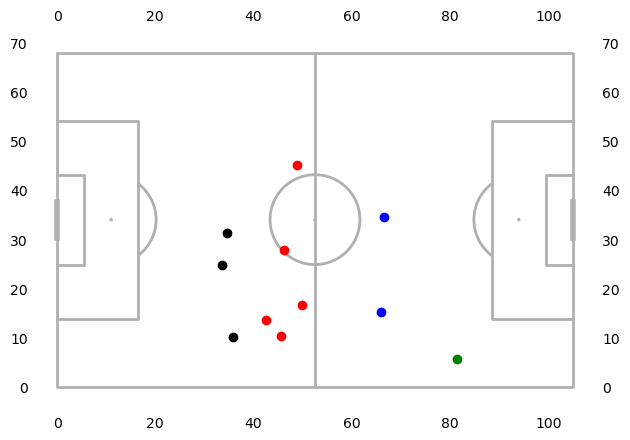

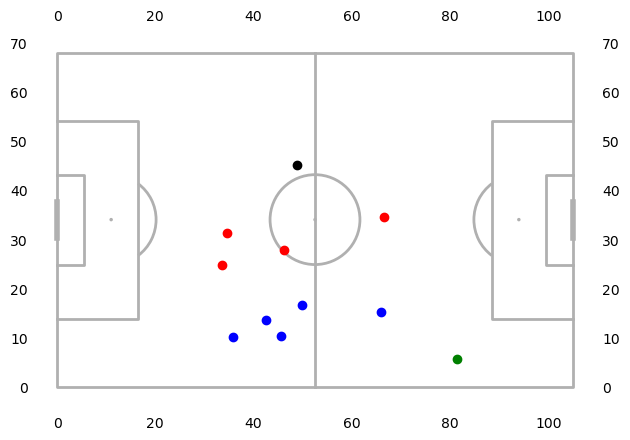

In [ ]:
press._plot()

In [ ]:
# | hide
from nbdev import nbdev_export
nbdev_export()